In [48]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
import statsmodels.api as sm 
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [5]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [6]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [7]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
nii_bo_dir = '../../data/niis'

In [9]:
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)

In [10]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [11]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [66]:
network_dir = '../../data/yeo_networks'

In [12]:
ddir = '../../data/'

In [13]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [14]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [15]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [16]:
template = se.helpers._gray(res=2)

In [17]:
network_list = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention',
                'Limbic ', 'Frontoparietal', 'Default']


In [18]:
factors=700

In [19]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [20]:
pieman_data = loadmat(pieman_name)

In [21]:
debug = False

In [22]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [23]:
data = np.array(data)
conds = np.array(conds)

In [68]:
n_nets = 7

In [69]:
yeo_colors = pd.read_fwf(os.path.join(network_dir, 'Yeo2011_' + str(n_nets) + 'Networks_ColorLUT.txt'))
yeo_colors.columns = ["inds", "networks", "x", "y", "z", "labels"]


In [70]:
if n_nets == 17:
    yeo_color_labels = ['visual peripheral', 'visual central', 'somatomotor A', 'somatomotor B', 'dorsal attention A', 
                        'dorsal attention B', 'ventral attention', 'salience', 'limbic A', 'limbic B', 'control C', 
                        'control A', 'control B', 'default D (auditory)', 'default C', 'default A', 'default B']
elif n_nets == 7:
    yeo_color_labels = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ',
                        'Frontoparietal', 'Default']
    
yeo_colors['labels'] = yeo_color_labels

In [71]:

color_stacked = np.array([])
for i in np.arange(0,n_nets+1):
    if color_stacked.shape[0]==0:
        color_stacked = yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values
    else:
        color_stacked = np.vstack((color_stacked, yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values))
color_stacked = color_stacked/255

## pieman pca decoding

In [212]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Visual.csv']


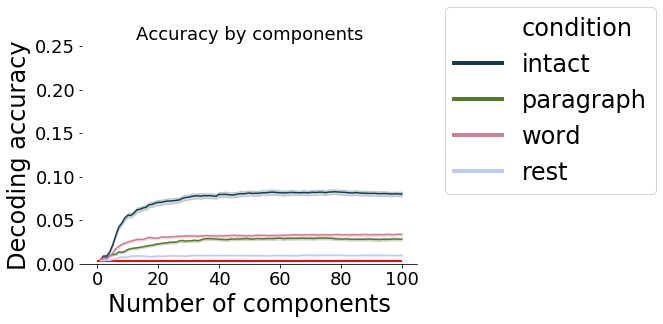

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Somatomotor.csv']


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

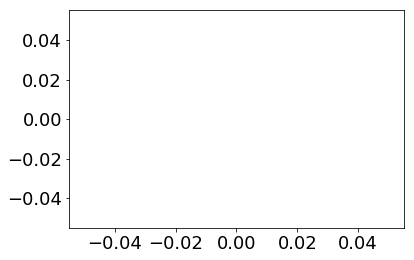

In [84]:
for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    print(conds)
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
    
    outfile = os.path.join(figdir, 'Accuracy_by_components_' + network_list[n] + '.pdf')
    
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    ax.set_title('Accuracy by components')
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
    #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    #fig.savefig(outfile, bbox_inches='tight')
    plt.show()
    plt.clf()

In [177]:
def func(x, a, b, c, d, g):

    return (((a-d)/((1+((x/c)** b))**g)) + d )

In [178]:
hill_all = np.zeros((7, 4))
maxs_all = np.zeros((7, 4))
spearmans_all= np.zeros((7, 4))

In [179]:
for n in np.arange(len(network_list)):

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)


    ydata = full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)
    
    hill_all[n, 0] = popt[1]
    
    max_i = ydata.max()
    
    maxs_all[n, 0] = max_i

    max_loc = np.where(ydata==max_i)[0][0]

    max_p = full_data[full_data['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_w = full_data[full_data['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_r = full_data[full_data['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


    spearmans_all[n, 0] = spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0]


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


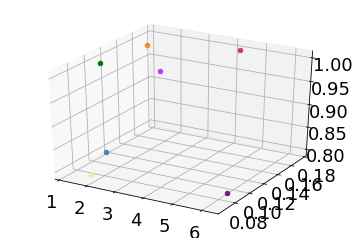

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for e in np.arange(n_nets):
    
    ax.scatter(hill_all[e, 0],maxs_all[e, 0],spearmans_all[e, 0], color=color_stacked[e])

In [213]:
hill_all = np.zeros((4, 7, 4))
maxs_all = np.zeros((4, 7, 4))

In [214]:
for n in np.arange(len(network_list)):

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

            
    conditions = ['intact', 'paragraph', 'word', 'rest']


    for e, c in enumerate(conditions):


        ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        
        i = 0
        
        hill_all[e, n, i] = popt[1]

        maxs_all[e, n, i] = ydata.max()


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [27]:
# outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

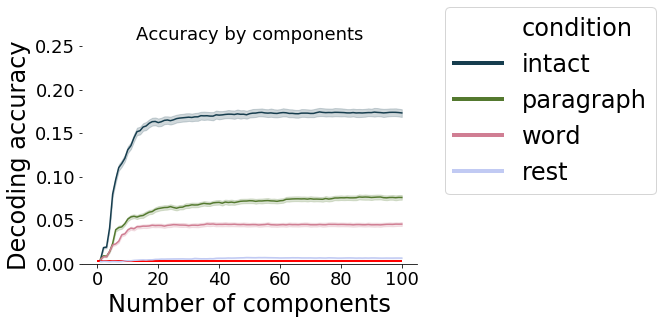

In [28]:
# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y="accuracy",
#              hue="condition",
#              data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
# sns.despine(ax=ax, left=True)
# ax.set_title('Accuracy by components')
# ax.set_ylabel('Decoding accuracy',fontsize=24)
# ax.set_xlabel('Number of components',fontsize=24)
# ax.set_ylim(0, .25)
# ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
# #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
# l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
# for line in l.get_lines():
#     line.set_linewidth(4.0)
# fig.savefig(outfile, bbox_inches='tight')

In [29]:
# full_data['diff'] = full_data.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(2)/2

In [30]:
# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y='diff',
#              hue="condition",
#              data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])

In [31]:

# lm = sns.lmplot(x="dims", y="diff",
#              hue="condition",
#              data=full_data, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
# axes = lm.axes
# axes[0,0].set_ylim(0,.02)
# axes[0,0].set_xlim(1,100)


In [215]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'

In [132]:

for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
            
    for i in range(3):
        full_data_temp = full_data[full_data['third']==i]

        ydata = full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=8000)
        
        hill_all[n, i+1] = popt[1]

        max_i = ydata.max()

        maxs_all[n, i+1] = max_i

        max_loc = np.where(ydata==max_i)[0][0]

        max_p = full_data_temp[full_data_temp['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
        max_w = full_data_temp[full_data_temp['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
        max_r = full_data_temp[full_data_temp['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


        spearmans_all[n, i+1] = spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0]


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [258]:

maxs_ns = np.zeros((7, 4, 4))
hills_ns = np.zeros((7, 4, 4))

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))

for n in np.arange(len(network_list)):
    

    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

            
    conditions = ['intact', 'paragraph', 'word', 'rest']

    hill_all = np.zeros((4, 4))
    maxs_all = np.zeros((4, 4))


    for e, c in enumerate(conditions):


        ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        
        hill_all[e, 0] = popt[1]

        maxs_all[e, 0] = ydata.max()
        
        
    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'
    
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    conditions = ['intact', 'paragraph', 'word', 'rest']

    for i in np.arange(1, 4):

        full_data_temp = full_data[full_data['third']==i-1]

        for e, c in enumerate(conditions):


            ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
            xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

            popt, pcov = curve_fit(func, xdata, ydata, maxfev=1000000)

            hill_all[e, i] = popt[1]

            maxs_all[e, i] = ydata.max()
            
    hills_ns[n, :, :] = maxs_all/hill_all
    
    maxs_ns[n, :, :] = maxs_all

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [262]:
hills_ns

array([[[1.33837444e-02, 2.41695502e-02, 2.99712561e-02, 3.46103780e-02],
        [2.38259110e-02, 2.07533488e-02, 8.08803259e-02, 1.93450860e-03],
        [4.12066308e-03, 3.87094854e-02, 8.79672125e-03, 1.63011803e-02],
        [6.40682693e-04, 1.60195560e-04, 5.66785757e-02, 1.02826005e-02]],

       [[8.95845036e-02, 1.79526948e-01, 8.10836217e-02, 1.42745992e-01],
        [8.28620456e-03, 4.70744638e-02, 3.84745389e-02, 1.61026557e-02],
        [2.79717261e-02, 6.80685965e-02, 1.05042458e-02, 3.57532309e-02],
        [7.54415101e-03, 2.00141952e-02, 1.70182027e-03, 4.42405518e-04]],

       [[7.70058915e-02, 9.13206792e-02, 1.25716382e-01, 8.61827293e-02],
        [3.36505366e-02, 2.11412520e-02, 9.78560714e-02, 3.98944670e-01],
        [2.76713340e-02, 1.92989548e-02, 1.02882306e-02, 2.96851385e-02],
        [3.48564585e-04, 4.04718377e-05, 1.03725506e-03, 9.04764510e-05]],

       [[3.36264764e-02, 5.45449472e-02, 9.00547958e-02, 2.92828024e-02],
        [2.62902703e-02, 7.52097

In [296]:
try_it = [n]*4

In [297]:
verts = [list(zip([0]*n,, [n]*4 ))]

In [312]:
[.2]*4

[0.2, 0.2, 0.2, 0.2]

In [313]:
verts = [list(zip([0]*4, [.2]*4, [n]*4))]

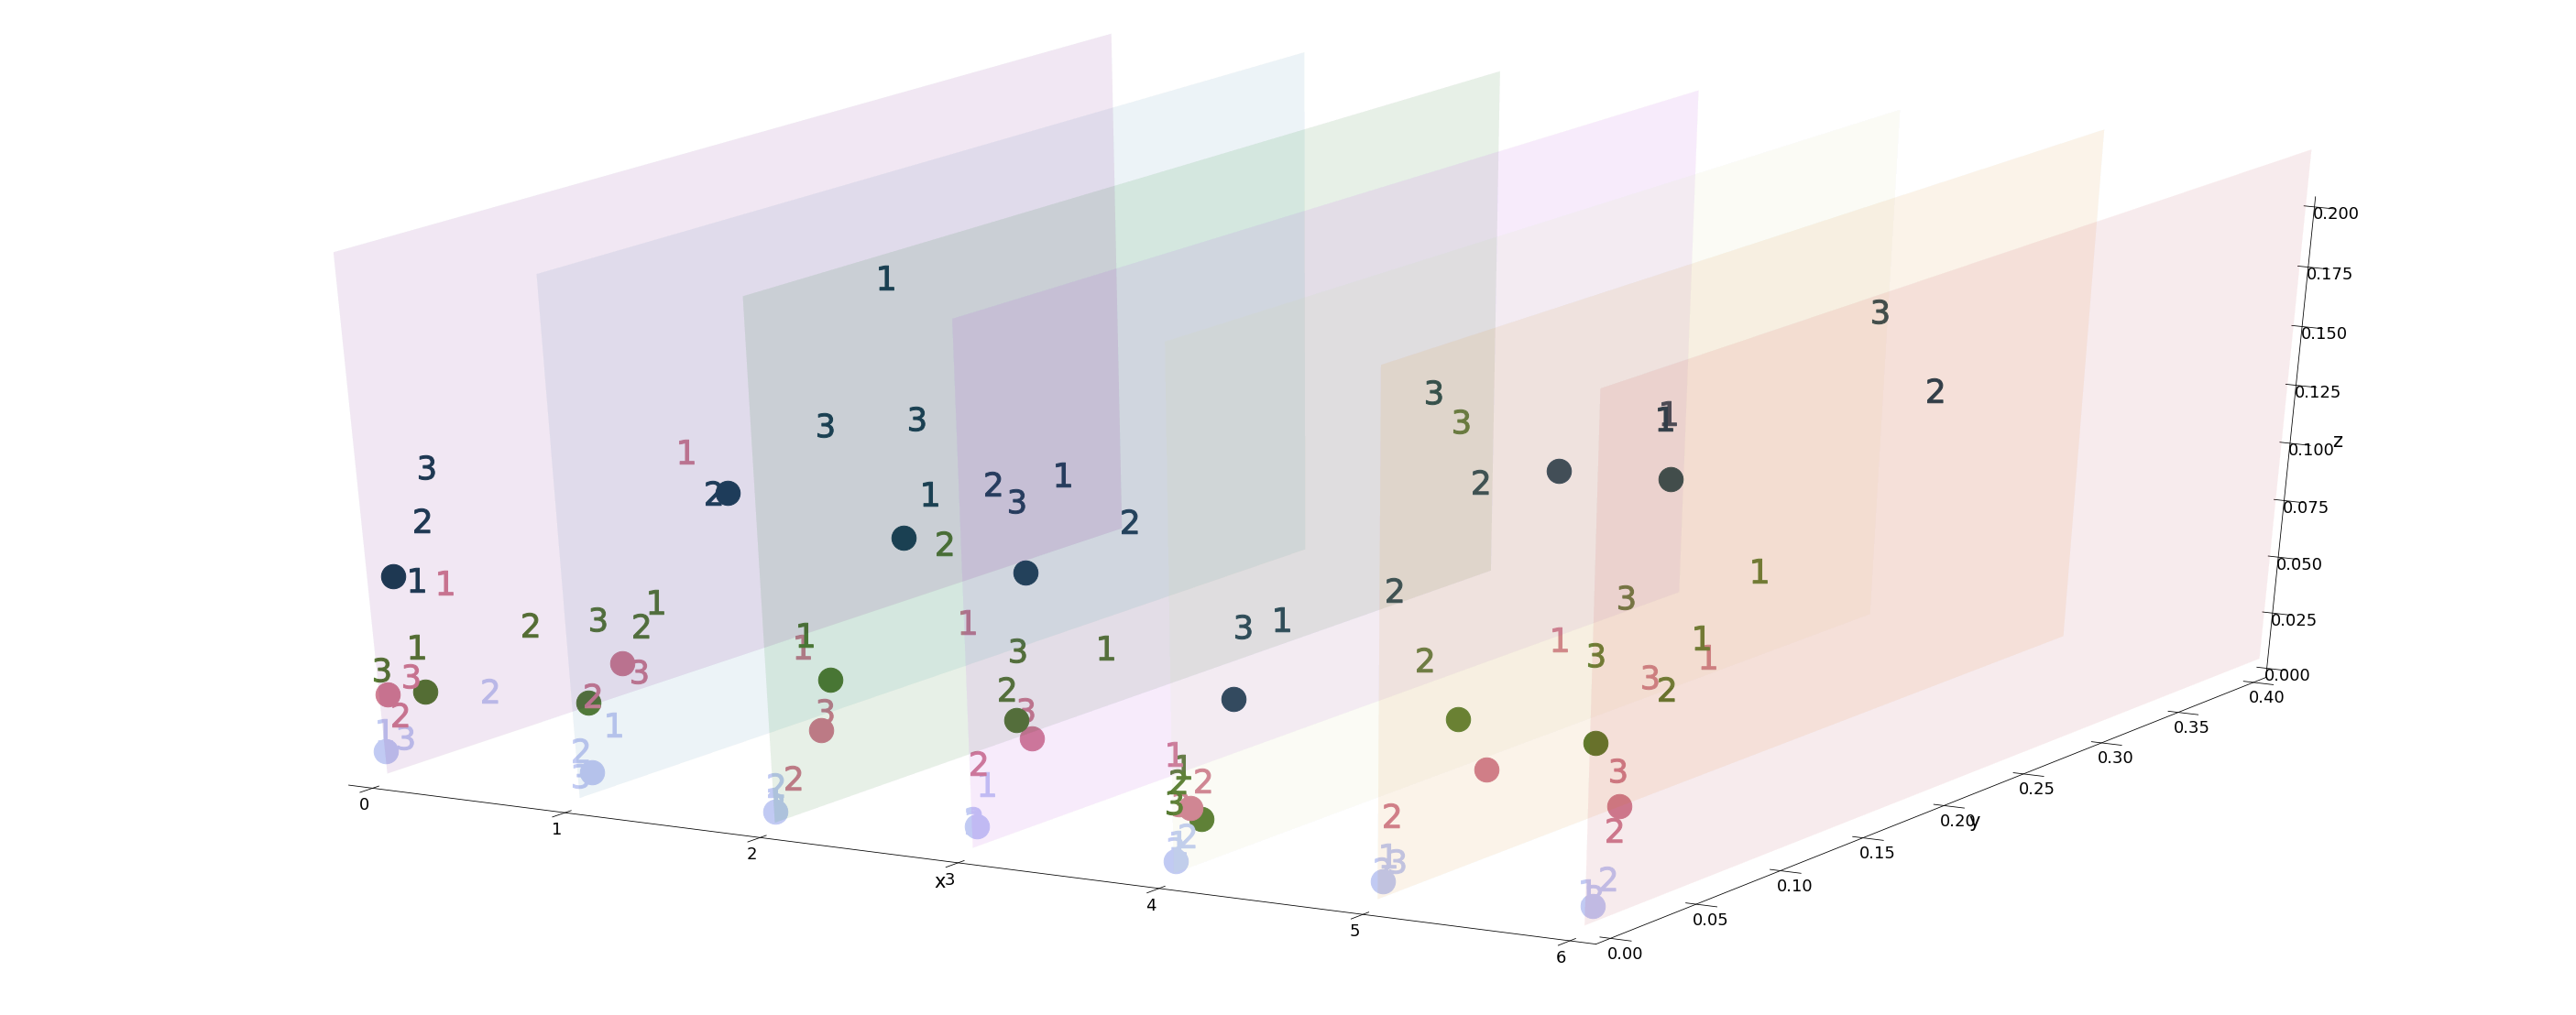

In [349]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(50,20))

ax=plt.subplot(projection='3d')

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_xlim(0,6)
ax.set_ylim(0,.4)
ax.set_zlim(0,.2)

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_list)):
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(n, 0.42, 0), (n, .42, 0.22), (n, 0, 0.22), (n, 0, 0),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.025, facecolor=color_stacked[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)
        
ax.plot(n, hills_ns[n, e, i],maxs_ns[1:],spearmans[1:],'x-')

for n in np.arange(len(network_list)):
    for e, c in enumerate(conditions):
        for i in np.arange(4):
            ax.scatter(n, hills_ns[n, e, i], maxs_ns[n, e, i], 
                        marker=markers[i], s=700, color=colors[e])



        
# for n in np.arange(len(network_list)):
#     for e, c in enumerate(conditions):
#         # 1. create vertices from points
#         #verts = [[(n, 0.42, 0), (n, .42, 0.22), (n, 0, 0.22), (n, 0, 0),]]
#         verts = [list(zip([n]*4, hills_ns[n, e], maxs_ns[n, e]))]
#         # 2. create 3d polygons and specify parameters
#         srf = Poly3DCollection(verts, alpha=.2, facecolor=color_stacked[n])
#         # 3. add polygon to the figure (current axes)
#         plt.gca().add_collection3d(srf)

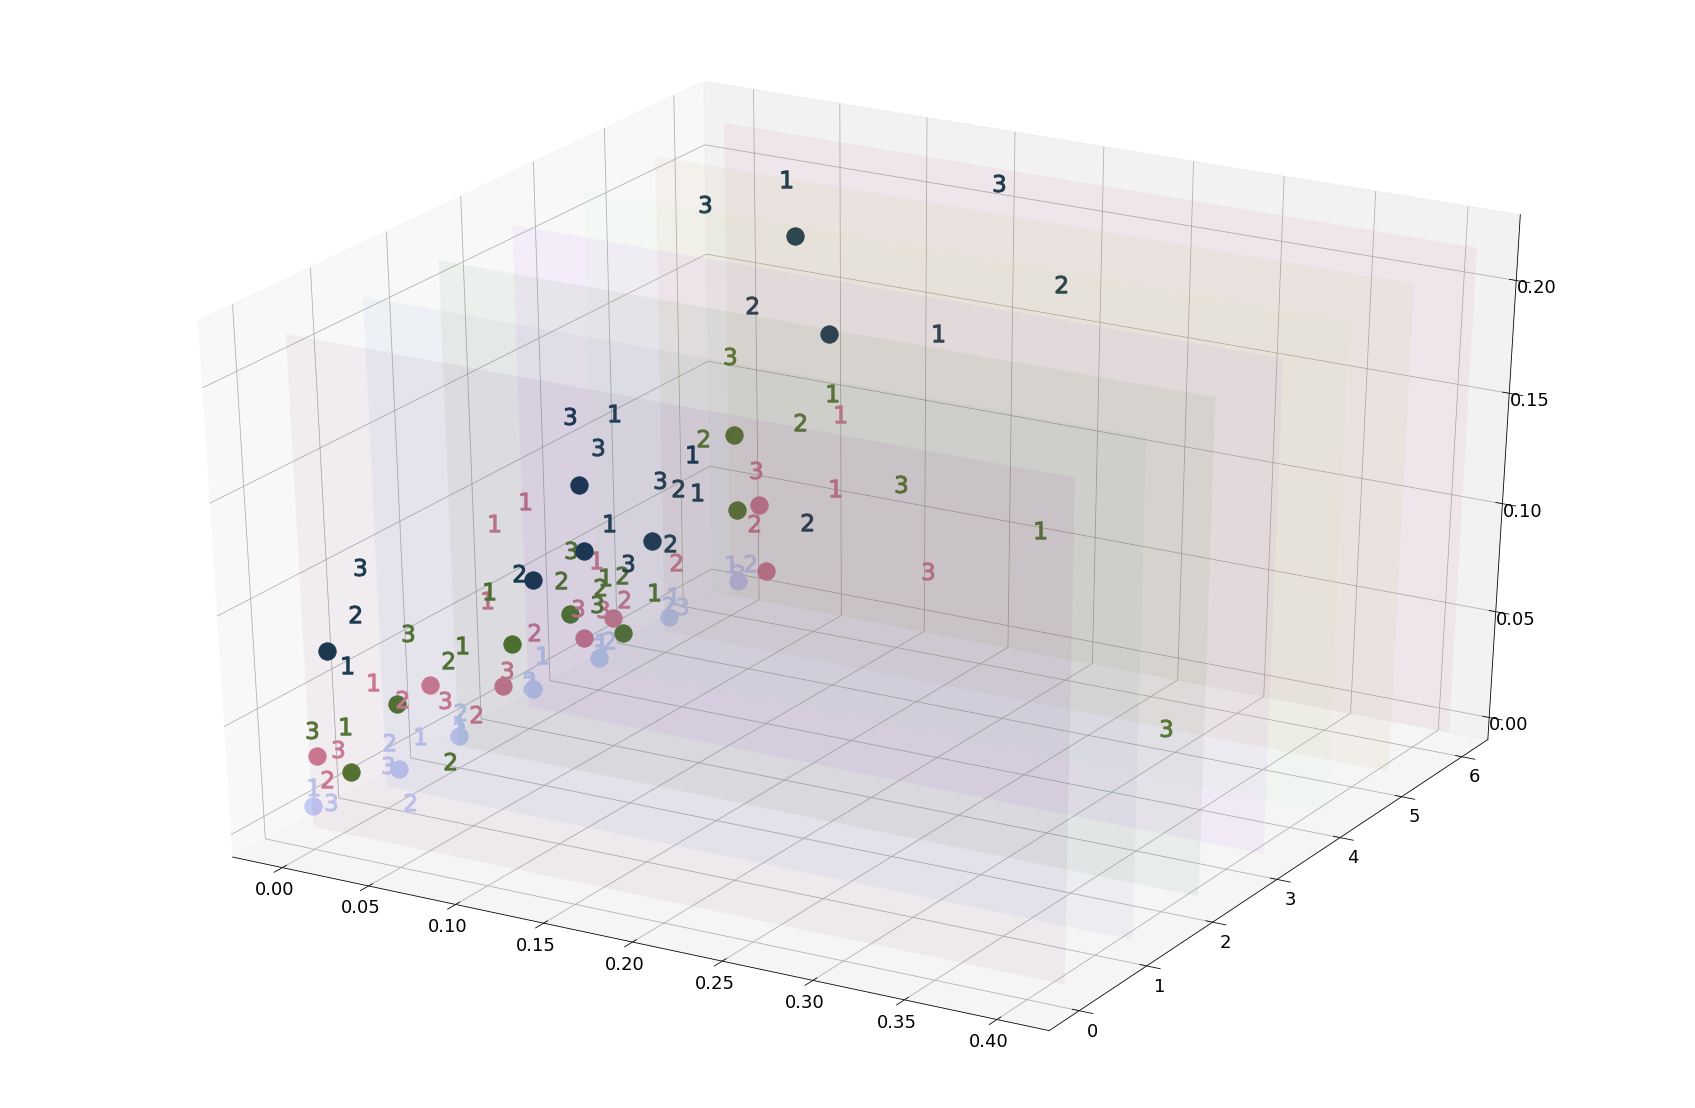

In [324]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(30,20))

custom=plt.subplot(projection='3d')

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_list)):
    for e, c in enumerate(conditions):
        for i in np.arange(4):
            custom.scatter(hills_ns[n, e, i], n, maxs_ns[n, e, i], 
                        marker=markers[i], s=300, color=colors[e])


for n in np.arange(len(network_list)):
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(0.42, n, 0), (.42, n, 0.22), (0, n, 0.22), (0, n, 0),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.01, facecolor=color_stacked[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)

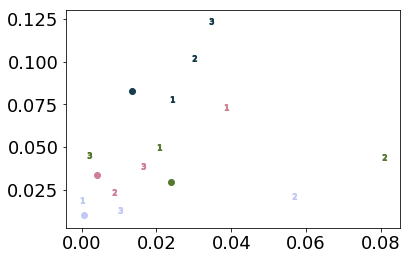

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(4):
        plt.scatter(hills_ns[e, 6, i],maxs_ns[e, 6, i], 
                    marker=markers[i], color=colors[e])

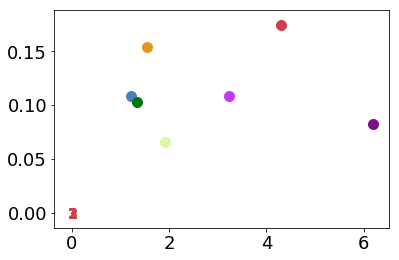

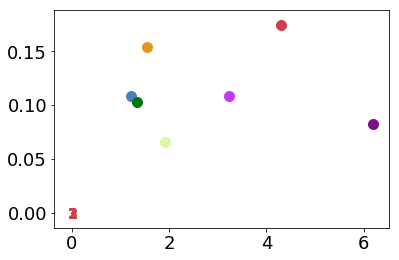

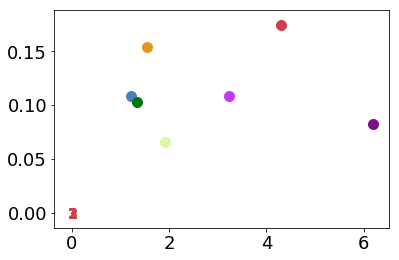

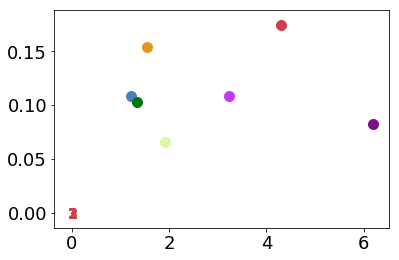

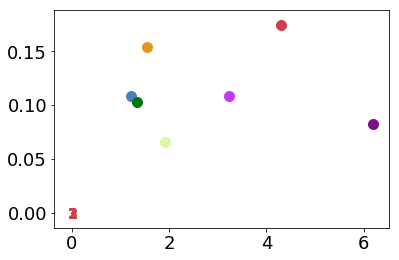

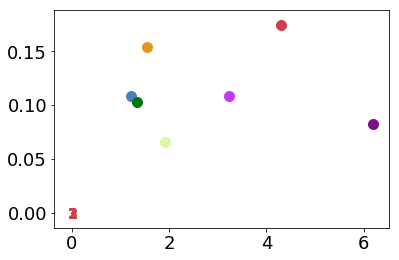

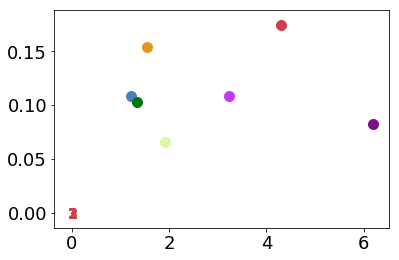

In [183]:

fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']

#ax.plot(hill[1:],maxs[1:],spearmans[1:],'x-')
for n in np.arange(len(network_list)):
    for i in np.arange(4):
    
        plt.scatter(hill_all[n, i],maxs_all[n, i], 
                   marker=markers[i], s=100, color=color_stacked[n])


In [181]:
conditions = ['intact', 'paragraph', 'word', 'rest']

for i in np.arange(1, 4):
    
    full_data_temp = full_data[full_data['third']==i-1]

    for e, c in enumerate(conditions):


        ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)

        hill_all[e, 0, i] = popt[1]

        maxs_all[e, 0, i] = ydata.max()


KeyError: 'third'

In [146]:
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [164]:
spearmans_all

array([[0.8, 0.8, 1. , 1. ],
       [0.8, 0.8, 1. , 1. ],
       [1. , 0.8, 1. , 1. ],
       [1. , 0.8, 1. , 1. ],
       [0.8, 0.8, 1. , 1. ],
       [1. , 0.8, 1. , 1. ],
       [1. , 1. , 1. , 1. ]])

IndexError: index 4 is out of bounds for axis 0 with size 4

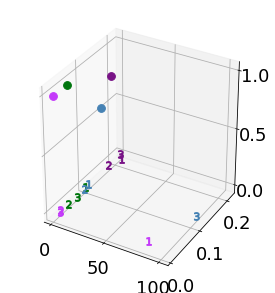

In [279]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(10,5))

custom=plt.subplot(121,projection='3d')

#custom.plot(hill[1:],maxs[1:],spearmans[1:],'x-', color='black')

for n in np.arange(len(network_list)):
    for i in np.arange(4):
    
        custom.scatter(hill_all[n, i],maxs_all[n, i],spearmans_all[n, i], 
                   marker=markers[i], s=60, color=color_stacked[n])
    
#for n in np.arange(len(network_list)):
for n in [6]:
    # 1. create vertices from points
    verts = [list(zip(hill_all[n], maxs_all[n], spearmans_all[n]))]
    # 2. create 3d polygons and specify parameters
    srf = Poly3DCollection(verts, alpha=.25, facecolor=color_stacked[n])
    # 3. add polygon to the figure (current axes)
    plt.gca().add_collection3d(srf)

In [150]:
hill_all[n]

array([1.33388063, 1.28667462, 0.90163269, 1.74338874])

In [144]:
hill_all[0]

array([6.19283593, 3.23961345, 3.41827515, 3.5769618 ])

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Visual.csv']
Visual
1


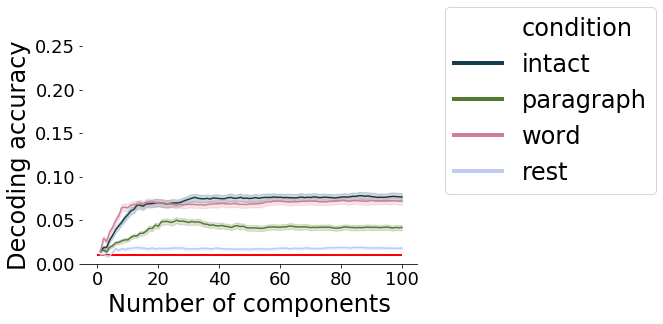

Visual
2


<Figure size 432x288 with 0 Axes>

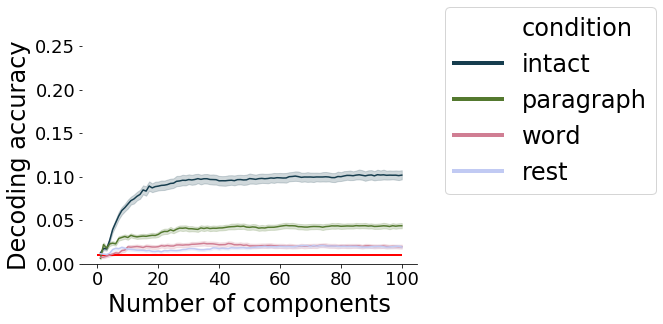

Visual
3


<Figure size 432x288 with 0 Axes>

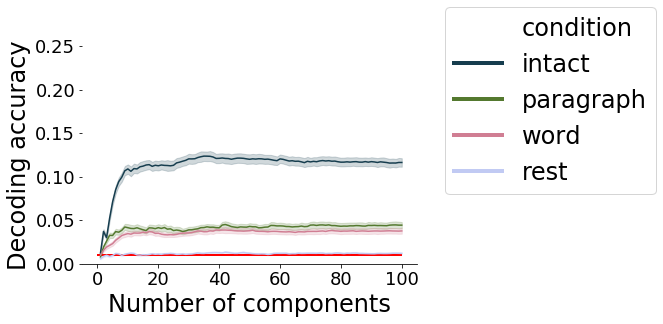

<Figure size 432x288 with 0 Axes>

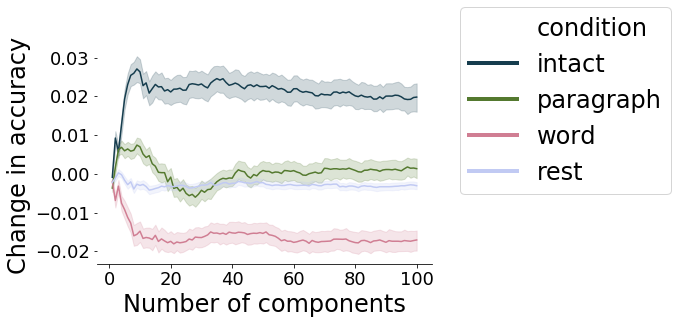

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Somatomotor.csv']
Somatomotor
1


<Figure size 432x288 with 0 Axes>

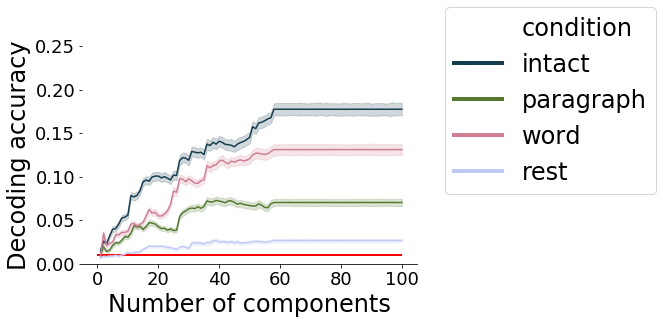

Somatomotor
2


<Figure size 432x288 with 0 Axes>

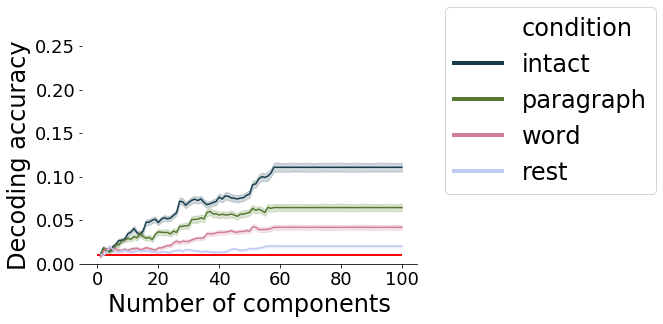

Somatomotor
3


<Figure size 432x288 with 0 Axes>

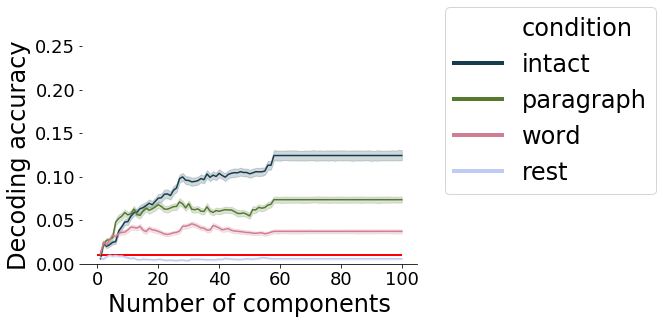

<Figure size 432x288 with 0 Axes>

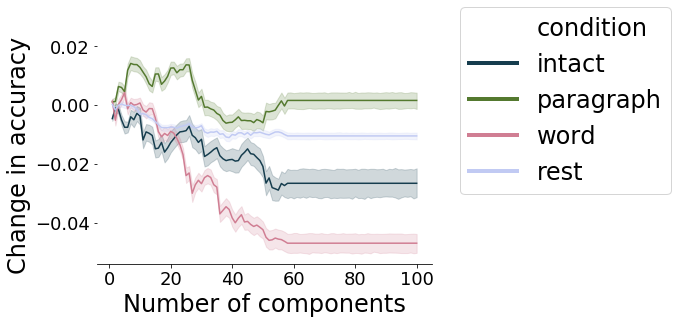

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Dorsal Attention.csv']
Dorsal Attention
1


<Figure size 432x288 with 0 Axes>

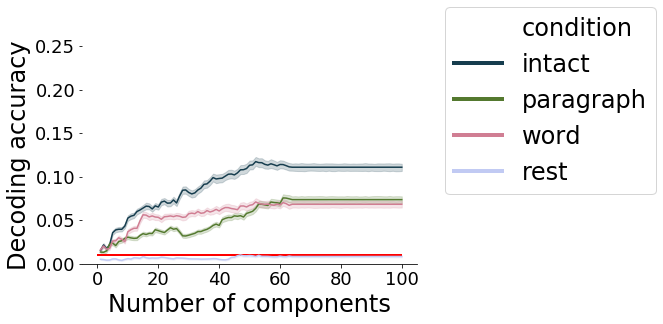

Dorsal Attention
2


<Figure size 432x288 with 0 Axes>

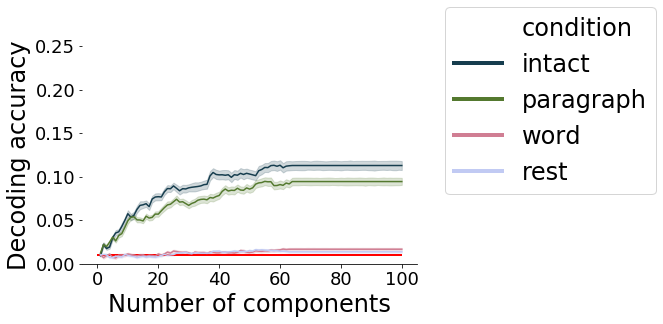

Dorsal Attention
3


<Figure size 432x288 with 0 Axes>

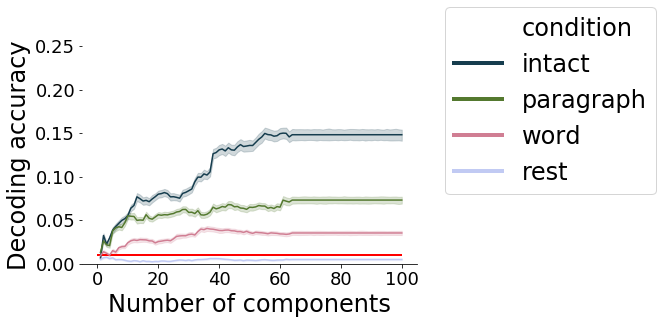

<Figure size 432x288 with 0 Axes>

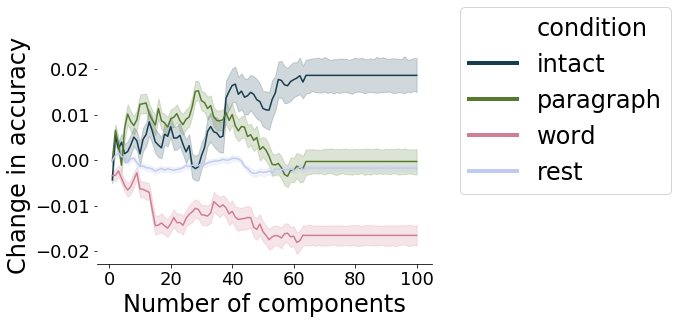

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Ventral Attention.csv']
Ventral Attention
1


<Figure size 432x288 with 0 Axes>

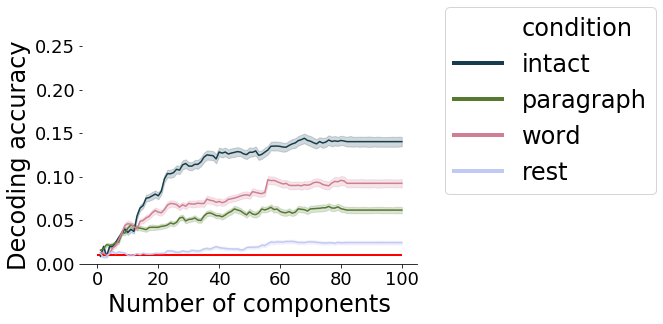

Ventral Attention
2


<Figure size 432x288 with 0 Axes>

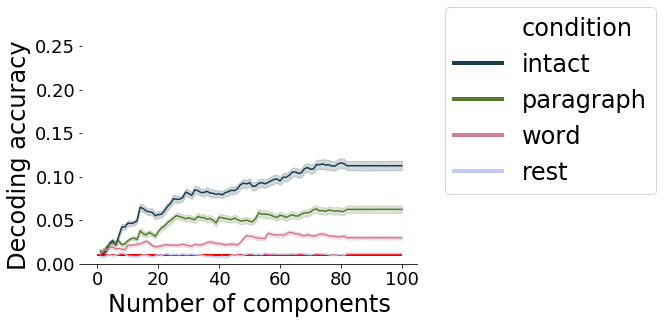

Ventral Attention
3


<Figure size 432x288 with 0 Axes>

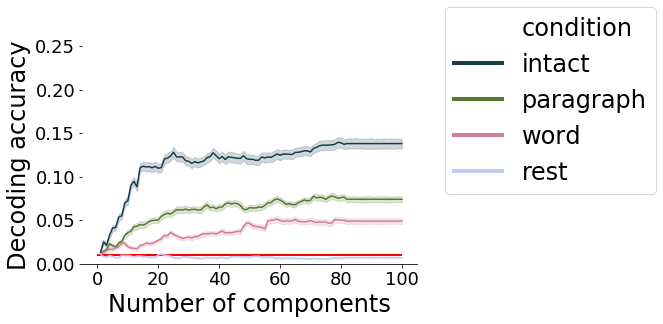

<Figure size 432x288 with 0 Axes>

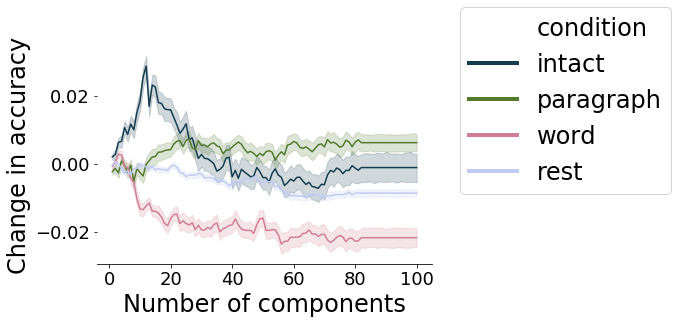

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Limbic .csv']
Limbic 
1


<Figure size 432x288 with 0 Axes>

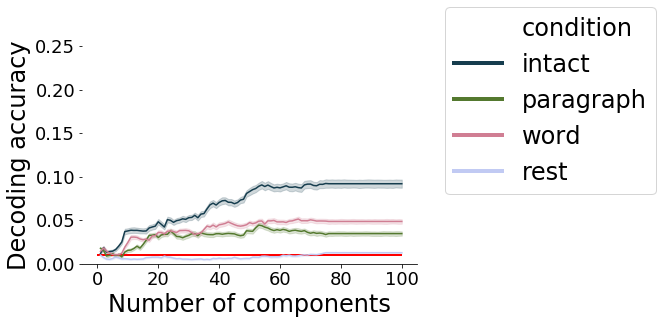

Limbic 
2


<Figure size 432x288 with 0 Axes>

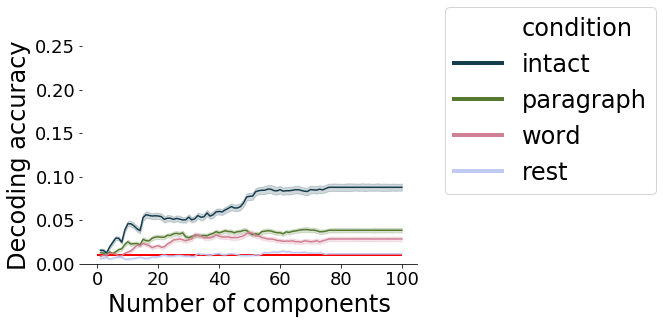

Limbic 
3


<Figure size 432x288 with 0 Axes>

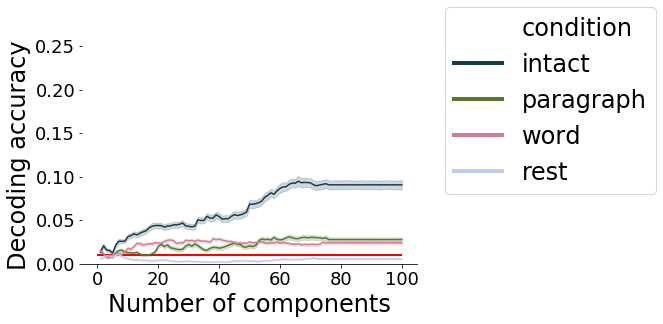

<Figure size 432x288 with 0 Axes>

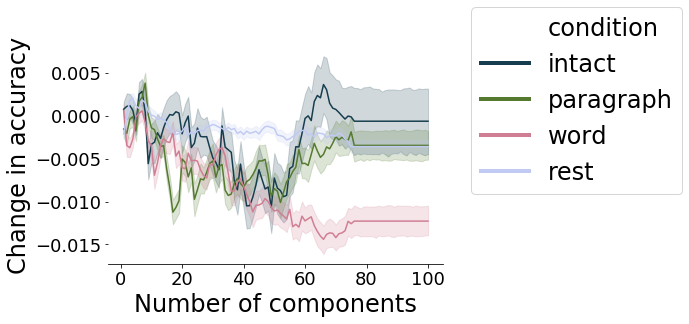

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Frontoparietal.csv']
Frontoparietal
1


<Figure size 432x288 with 0 Axes>

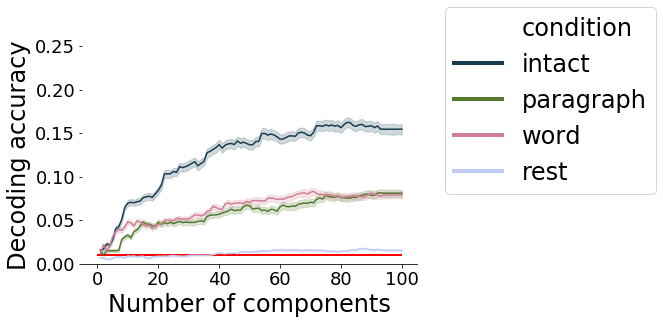

Frontoparietal
2


<Figure size 432x288 with 0 Axes>

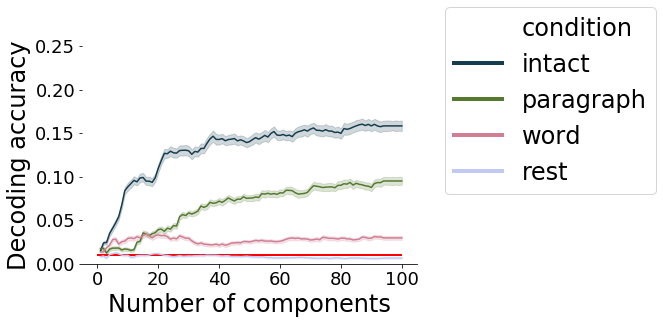

Frontoparietal
3


<Figure size 432x288 with 0 Axes>

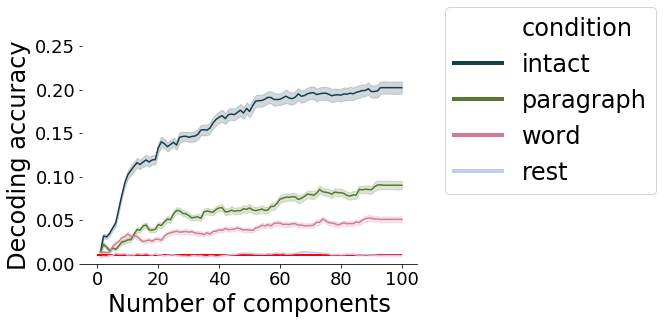

<Figure size 432x288 with 0 Axes>

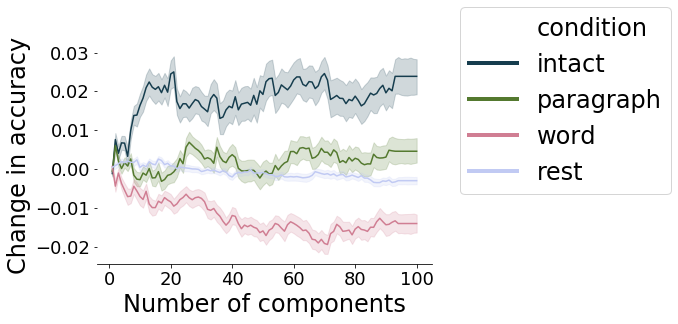

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Default.csv']
Default
1


<Figure size 432x288 with 0 Axes>

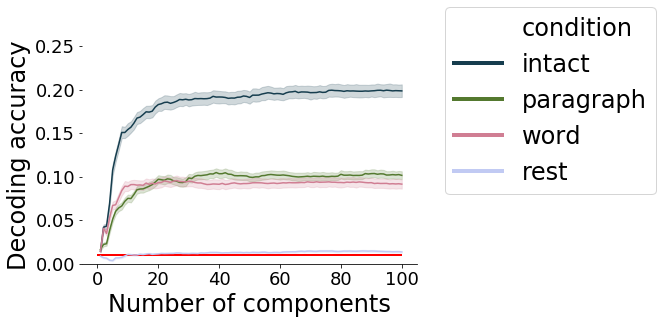

Default
2


<Figure size 432x288 with 0 Axes>

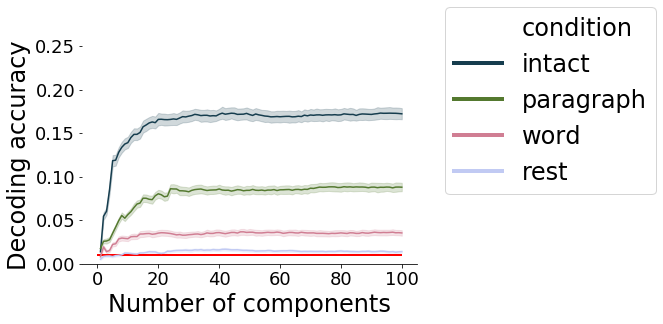

Default
3


<Figure size 432x288 with 0 Axes>

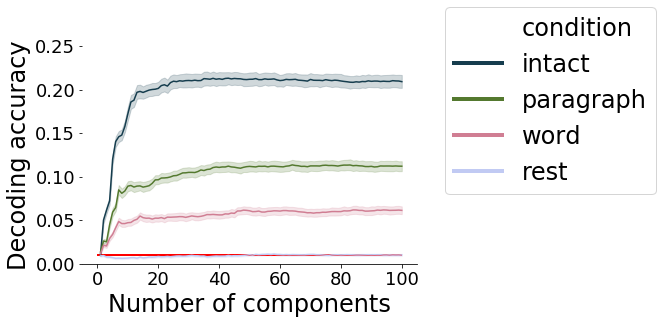

<Figure size 432x288 with 0 Axes>

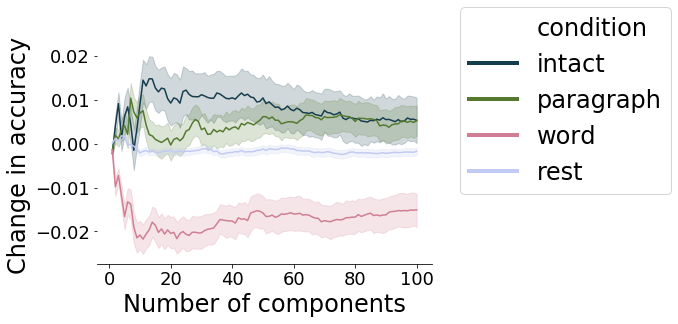

<Figure size 432x288 with 0 Axes>

In [34]:
for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    print(conds)
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
            
    for i in range(3):
        print(network_list[n])
        print(i+1)
        outfile = os.path.join(figdir, 'Accuracy_by_components_' + network_list[n] + '_third_' + str(i) + '.pdf')
        fig, ax = plt.subplots()
        sns.lineplot(x="dims", y="accuracy",
                     hue="condition",
                     data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
        sns.despine(ax=ax, left=True)
        #ax.set_title('Accuracy by components for third: ' + str(i + 1))
        ax.set_ylabel('Decoding accuracy',fontsize=24)
        ax.set_xlabel('Number of components',fontsize=24)
        ax.set_ylim(0, .25)
        ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
        l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
        for line in l.get_lines():
            line.set_linewidth(4.0)
        #fig.savefig(outfile, bbox_inches='tight')
        plt.show()
        plt.clf()
        
    data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()
    outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="third",
                 hue="condition",
                 data=data_regression, palette="cubehelix", 
               hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Change in accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)

    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    #fig.savefig(outfile, bbox_inches='tight')
    plt.show()
    plt.clf()

In [35]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,third,condition
0,0,0.7788,0.01,0.4544,1,0,0,0,intact
1,0,0.7950,0.03,0.2493,2,0,0,0,intact
2,0,0.8110,0.02,0.3277,3,0,0,0,intact
3,0,0.8821,0.05,0.2320,4,0,0,0,intact
4,0,0.9294,0.10,0.1760,5,0,0,0,intact


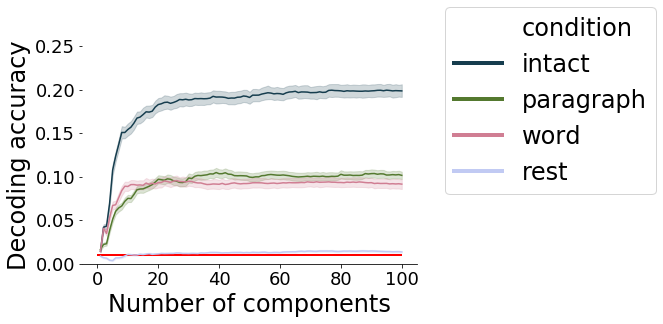

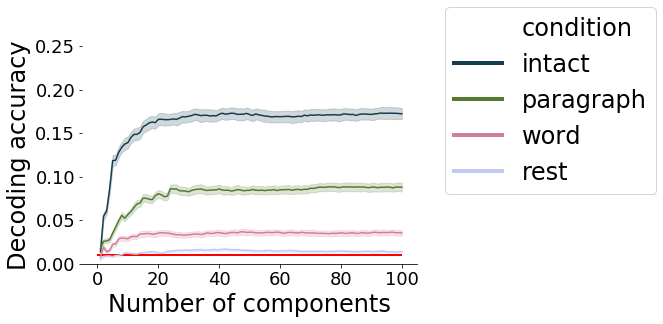

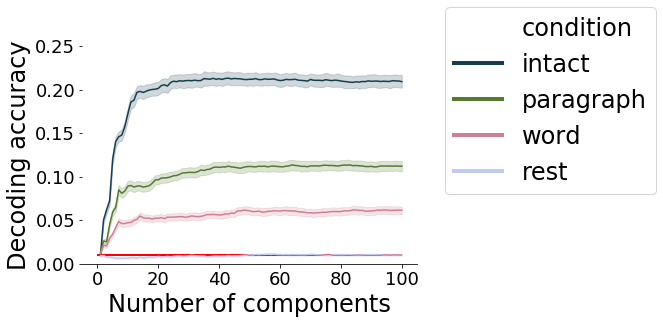

In [36]:
for i in range(3):
    outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')
    

In [37]:
data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()

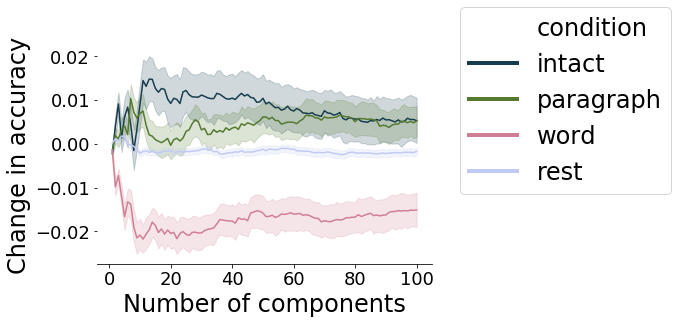

In [38]:
outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

fig, ax = plt.subplots()
sns.lineplot(x="dims", y="third",
             hue="condition",
             data=data_regression, palette="cubehelix", 
           hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components for third: ' + str(i + 1))
ax.set_ylabel('Change in accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)

l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [39]:
# for i in range(3):
#     full_data_temp = full_data[full_data['third']==i].reset_index(drop=True)
#     full_data_temp['diff'] = full_data_temp.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(5)/5
#     fig, ax = plt.subplots()
#     sns.lineplot(x="dims", y="diff",
#              hue="condition",
#              data=full_data_temp, palette="cubehelix", 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
#     sns.despine(ax=ax, left=True)
#     ax.set_title('Accuracy by components')
#     ax.set_ylabel('Decoding accuracy',fontsize=24)
#     ax.set_xlabel('Number of components',fontsize=24)
#     ax.set_ylim(0, .03)
#     ax.set_xlim(5, 100)
#     #ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#     #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
#     l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
#     for line in l.get_lines():
#         line.set_linewidth(4.0)
#     fig.savefig(outfile, bbox_inches='tight')
#     plt.show()
#     plt.clf()
# #     lm = sns.lmplot(x="dims", y="diff",
# #              hue="condition",
# #              data=full_data, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
# #            hue_order=['intact', 'paragraph', 'word', 'rest'])
# #     axes = lm.axes
# #     axes[0,0].set_ylim(0,.02)
# #     axes[0,0].set_xlim(1,100)

In [40]:
# for i in range(3):
#     full_data_temp = full_data[full_data['third']==i].reset_index(drop=True)
#     full_data_temp['diff'] = full_data_temp.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(2)/2
# #     sns.lineplot(x="dims", y="diff",
# #              hue="condition",
# #              data=full_data_temp, palette="cubehelix", 
# #            hue_order=['intact', 'paragraph', 'word', 'rest'])
    
#     lm = sns.lmplot(x="dims", y="diff",
#              hue="condition", data=full_data_temp, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
#     axes = lm.axes
#     axes[0,0].set_ylim(0,.025)
#     axes[0,0].set_xlim(3,100)
#     plt.show()
#     plt.clf()